## 1. Import required libraries

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Clustering and analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Statistical analysis
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization parameters
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load dataset
df = pd.read_csv('ai_jobs_data_cleaned.csv')

# Validation checks
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nMissing values per column:")
print(df.isnull().sum())

# Create subset for clustering (remove any remaining nulls)
cluster_df = df.dropna(subset=['salary_usd', 'years_experience', 'remote_ratio', 'benefits_score'])
print(f"Clustering dataset shape: {cluster_df.shape}")

Dataset shape: (15000, 19)
Memory usage: 12.32 MB

Missing values per column:
job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64
Clustering dataset shape: (15000, 19)


=== SALARY DISTRIBUTION ANALYSIS ===
count     15000.000000
mean     115348.965133
std       60260.940438
min       32519.000000
25%       70179.750000
50%       99705.000000
75%      146408.500000
max      399095.000000
Name: salary_usd, dtype: float64


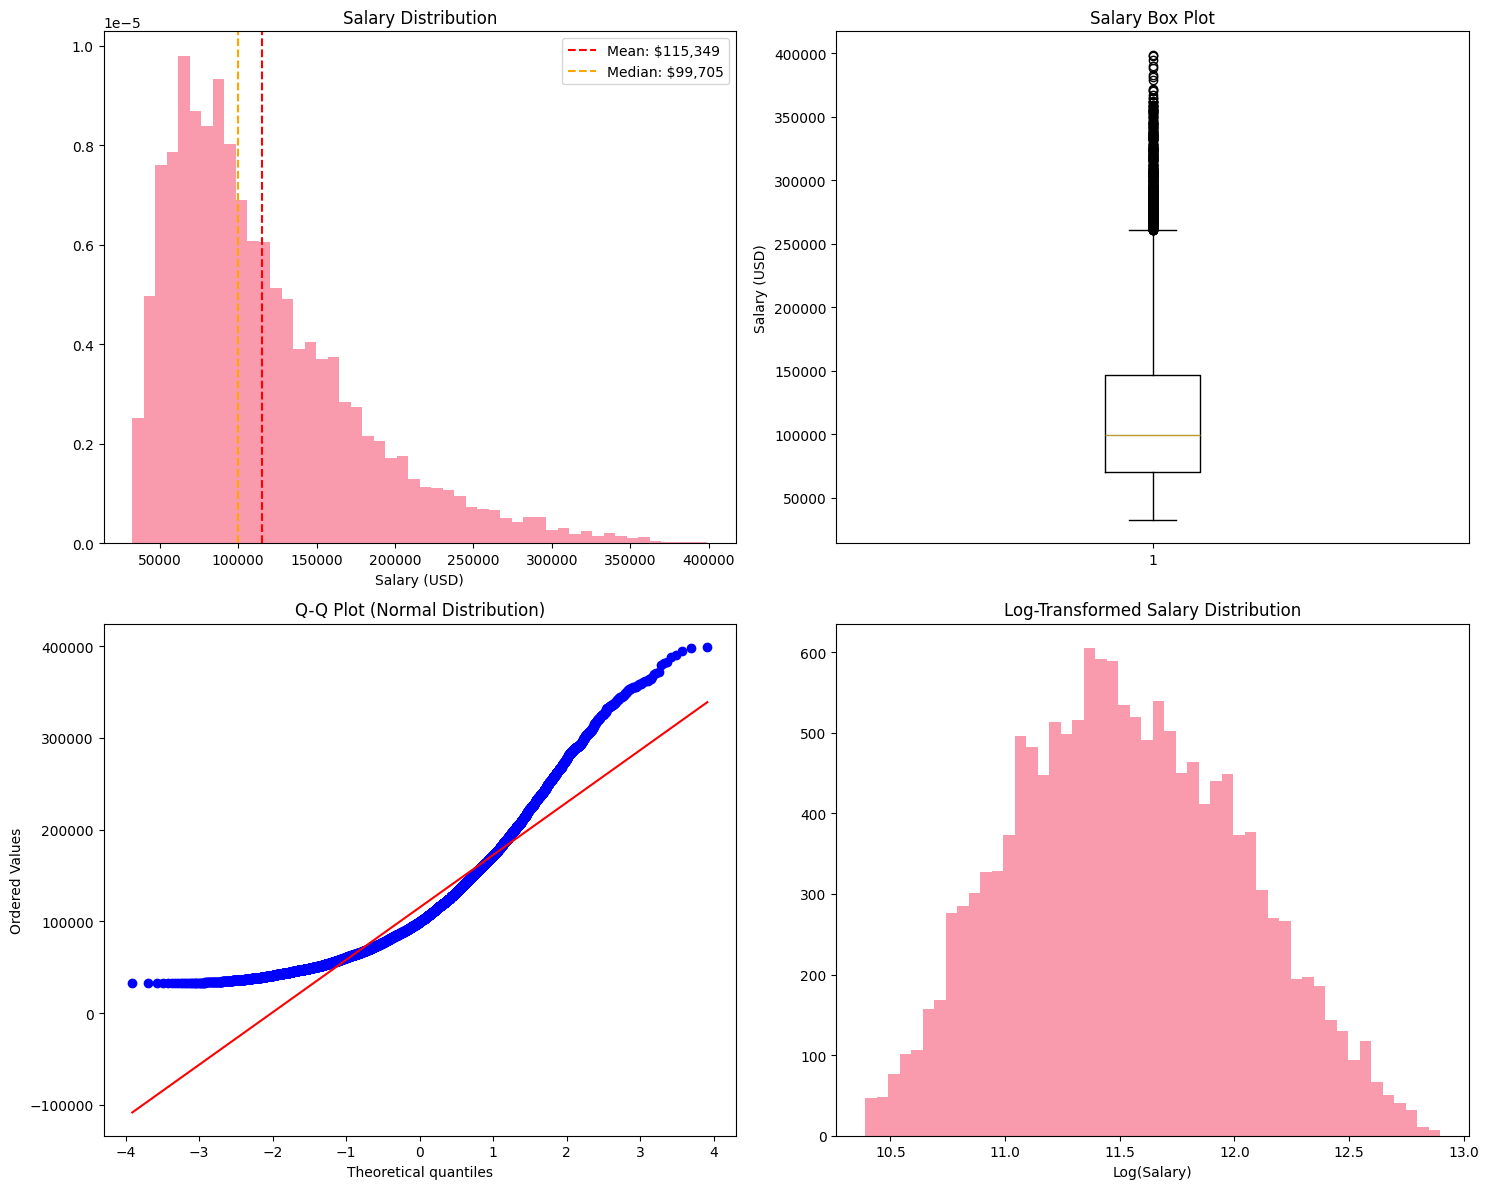


Salary Percentiles:
10th percentile: $53,088
25th percentile: $70,180
50th percentile: $99,705
75th percentile: $146,408
90th percentile: $199,217
95th percentile: $237,988
99th percentile: $307,776


In [3]:
def analyze_salary_distribution(df):
    """Comprehensive salary analysis"""
    
    # Basic statistics
    salary_stats = df['salary_usd'].describe()
    print("=== SALARY DISTRIBUTION ANALYSIS ===")
    print(salary_stats)
    
    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Histogram with KDE
    axes[0,0].hist(df['salary_usd'], bins=50, alpha=0.7, density=True)
    axes[0,0].axvline(df['salary_usd'].mean(), color='red', linestyle='--', label=f'Mean: ${df["salary_usd"].mean():,.0f}')
    axes[0,0].axvline(df['salary_usd'].median(), color='orange', linestyle='--', label=f'Median: ${df["salary_usd"].median():,.0f}')
    axes[0,0].set_title('Salary Distribution')
    axes[0,0].set_xlabel('Salary (USD)')
    axes[0,0].legend()
    
    # Box plot
    axes[0,1].boxplot(df['salary_usd'])
    axes[0,1].set_title('Salary Box Plot')
    axes[0,1].set_ylabel('Salary (USD)')
    
    # Q-Q plot for normality
    stats.probplot(df['salary_usd'], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normal Distribution)')
    
    # Log-transformed distribution
    log_salary = np.log(df['salary_usd'] + 1)
    axes[1,1].hist(log_salary, bins=50, alpha=0.7)
    axes[1,1].set_title('Log-Transformed Salary Distribution')
    axes[1,1].set_xlabel('Log(Salary)')
    
    plt.tight_layout()
    plt.savefig('salary_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Percentile analysis
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    salary_percentiles = df['salary_usd'].quantile([p/100 for p in percentiles])
    
    print("\nSalary Percentiles:")
    for p, val in zip(percentiles, salary_percentiles):
        print(f"{p}th percentile: ${val:,.0f}")
    
    return salary_stats, salary_percentiles

# Execute salary analysis
salary_stats, salary_percentiles = analyze_salary_distribution(df)

=== EXPERIENCE DISTRIBUTION ANALYSIS ===

Experience Level Distribution:
experience_level
MI    3781
EX    3760
SE    3741
EN    3718
Name: count, dtype: int64

Experience Level Percentages:
experience_level
MI    25.21
EX    25.07
SE    24.94
EN    24.79
Name: count, dtype: float64

Years of Experience Statistics:
count    15000.000000
mean         6.253200
std          5.545768
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         19.000000
Name: years_experience, dtype: float64


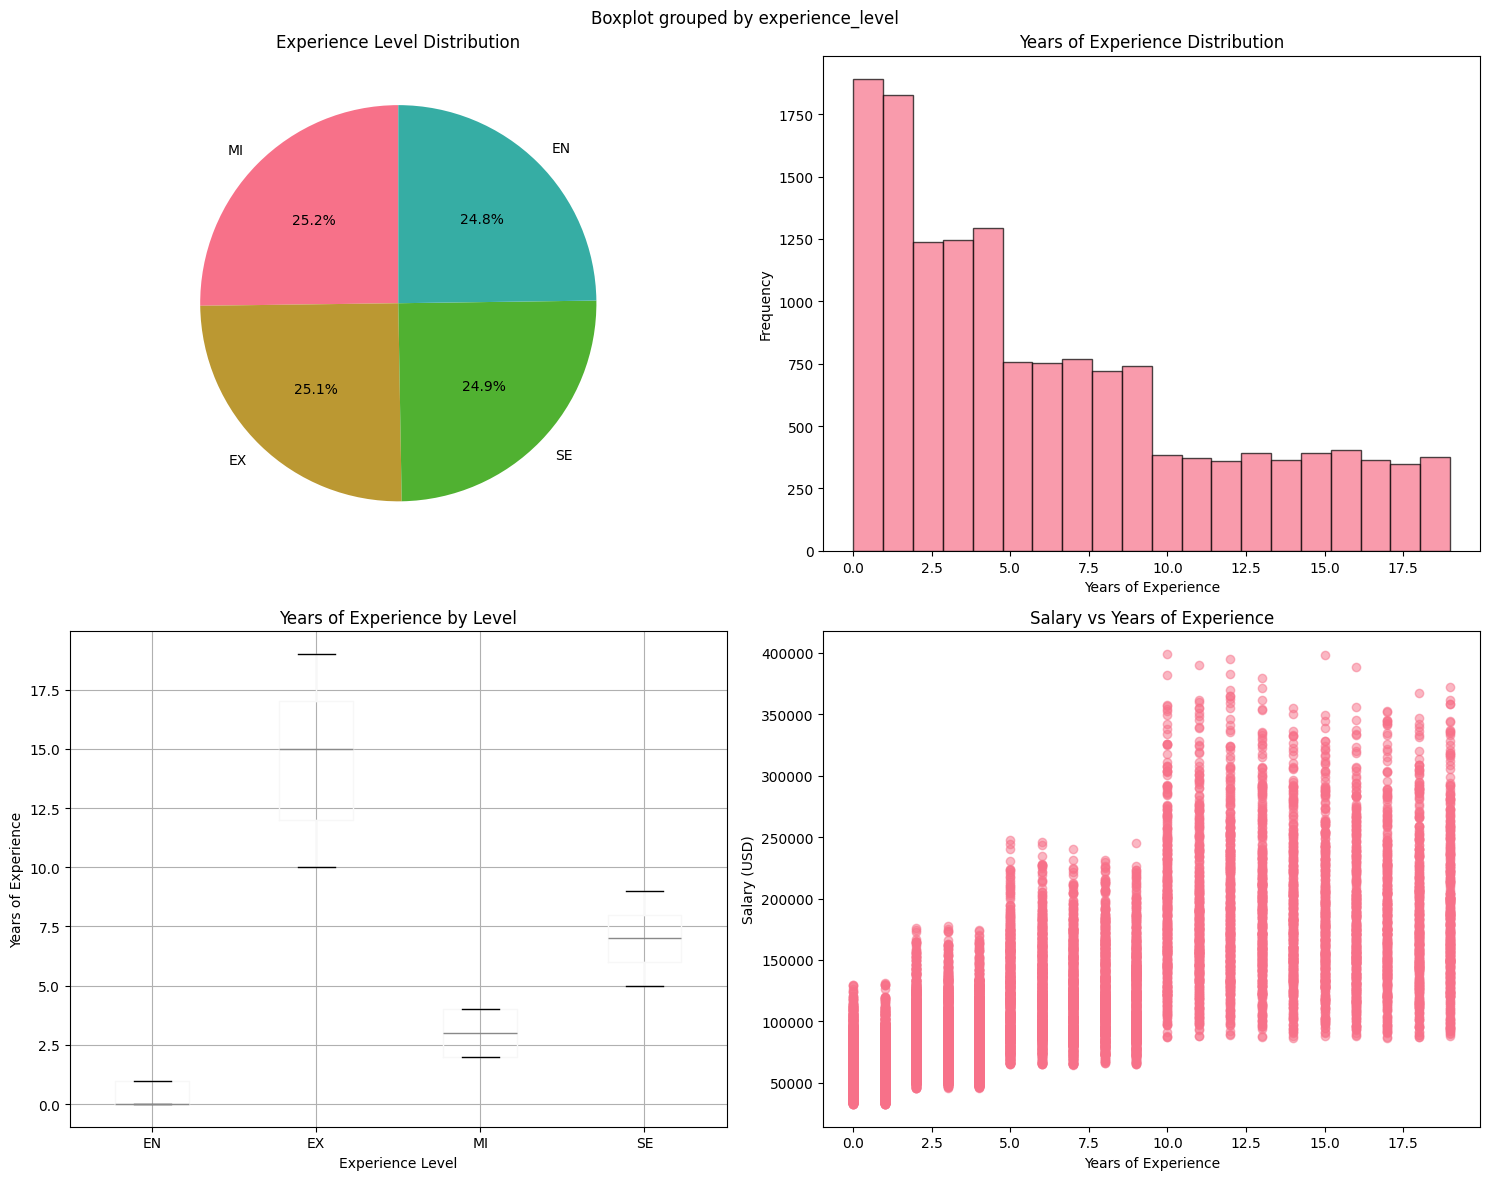

In [4]:
def analyze_experience_distribution(df):
    """Analyze experience levels and years"""
    
    print("=== EXPERIENCE DISTRIBUTION ANALYSIS ===")
    
    # Experience level counts
    exp_level_counts = df['experience_level'].value_counts()
    print("\nExperience Level Distribution:")
    print(exp_level_counts)
    print(f"\nExperience Level Percentages:")
    print((exp_level_counts / len(df) * 100).round(2))
    
    # Years of experience statistics
    exp_years_stats = df['years_experience'].describe()
    print(f"\nYears of Experience Statistics:")
    print(exp_years_stats)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Experience level pie chart
    axes[0,0].pie(exp_level_counts.values, labels=exp_level_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Experience Level Distribution')
    
    # Years experience histogram
    axes[0,1].hist(df['years_experience'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Years of Experience Distribution')
    axes[0,1].set_xlabel('Years of Experience')
    axes[0,1].set_ylabel('Frequency')
    
    # Experience level vs years boxplot
    df.boxplot(column='years_experience', by='experience_level', ax=axes[1,0])
    axes[1,0].set_title('Years of Experience by Level')
    axes[1,0].set_xlabel('Experience Level')
    axes[1,0].set_ylabel('Years of Experience')
    
    # Salary vs experience scatter
    axes[1,1].scatter(df['years_experience'], df['salary_usd'], alpha=0.5)
    axes[1,1].set_title('Salary vs Years of Experience')
    axes[1,1].set_xlabel('Years of Experience')
    axes[1,1].set_ylabel('Salary (USD)')
    
    plt.tight_layout()
    plt.savefig('experience_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return exp_level_counts, exp_years_stats

# Execute experience analysis
exp_level_counts, exp_years_stats = analyze_experience_distribution(df)

=== GEOGRAPHIC DISTRIBUTION ANALYSIS ===
Top 15 Company Locations:
company_location
Germany        814
Denmark        778
Canada         769
France         769
Austria        765
Singapore      764
China          763
India          754
Sweden         752
Israel         751
Ireland        750
Switzerland    746
Japan          733
Finland        733
Australia      732
Name: count, dtype: int64

Top 15 Employee Residence Locations:
employee_residence
Sweden            790
France            781
Denmark           777
Austria           776
India             772
Germany           769
South Korea       763
Canada            762
China             761
Netherlands       758
United Kingdom    750
Switzerland       748
Ireland           740
Singapore         740
Israel            731
Name: count, dtype: int64

Remote Work Ratio Statistics:
count    15000.000000
mean        49.483333
std         40.812712
min          0.000000
25%          0.000000
50%         50.000000
75%        100.000000
max    

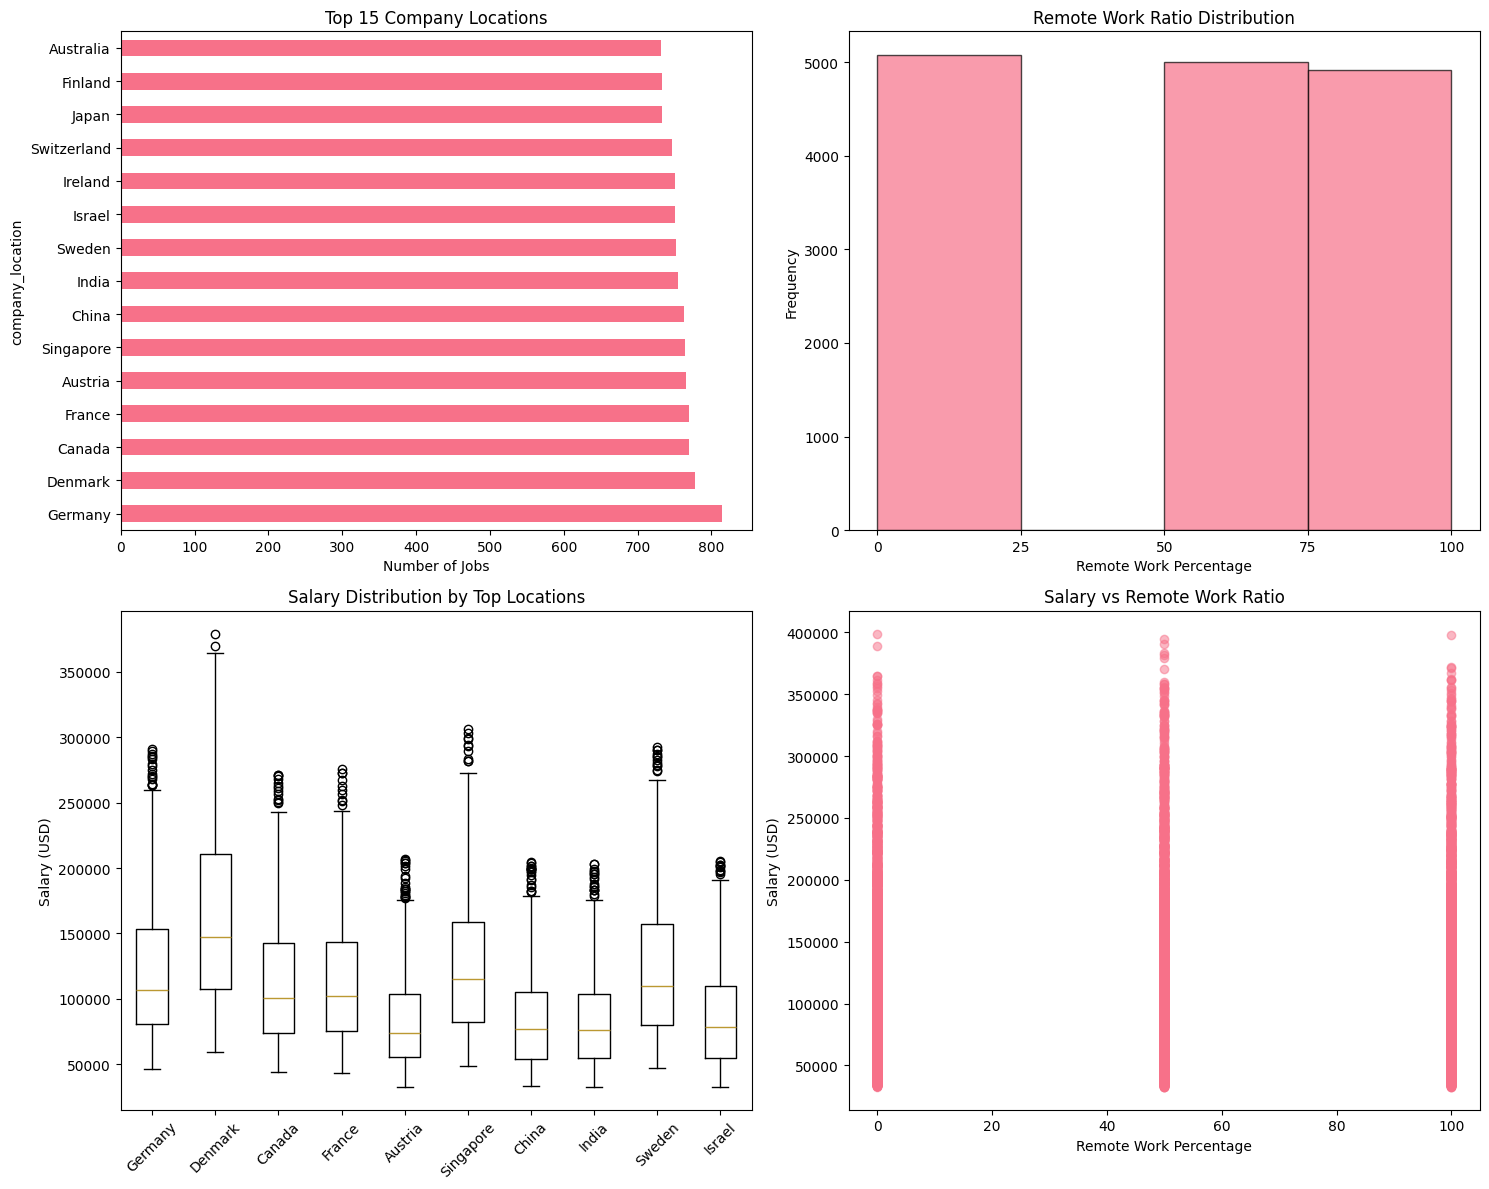

In [5]:
def analyze_geographic_distribution(df):
    """Analyze geographic patterns"""
    
    print("=== GEOGRAPHIC DISTRIBUTION ANALYSIS ===")
    
    # Company location analysis
    location_counts = df['company_location'].value_counts().head(15)
    print("Top 15 Company Locations:")
    print(location_counts)
    
    # Employee residence analysis
    residence_counts = df['employee_residence'].value_counts().head(15)
    print("\nTop 15 Employee Residence Locations:")
    print(residence_counts)
    
    # Remote work analysis
    remote_stats = df['remote_ratio'].describe()
    print(f"\nRemote Work Ratio Statistics:")
    print(remote_stats)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Top company locations bar chart
    location_counts.plot(kind='barh', ax=axes[0,0])
    axes[0,0].set_title('Top 15 Company Locations')
    axes[0,0].set_xlabel('Number of Jobs')
    
    # Remote ratio distribution
    axes[0,1].hist(df['remote_ratio'], bins=[0, 25, 50, 75, 100], alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Remote Work Ratio Distribution')
    axes[0,1].set_xlabel('Remote Work Percentage')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_xticks([0, 25, 50, 75, 100])
    
    # Salary by location (top 10)
    top_locations = location_counts.head(10).index
    location_salary_data = []
    for loc in top_locations:
        location_salary_data.append(df[df['company_location'] == loc]['salary_usd'].values)
    
    axes[1,0].boxplot(location_salary_data, labels=[loc[:10] for loc in top_locations])
    axes[1,0].set_title('Salary Distribution by Top Locations')
    axes[1,0].set_ylabel('Salary (USD)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Remote ratio vs salary
    axes[1,1].scatter(df['remote_ratio'], df['salary_usd'], alpha=0.5)
    axes[1,1].set_title('Salary vs Remote Work Ratio')
    axes[1,1].set_xlabel('Remote Work Percentage')
    axes[1,1].set_ylabel('Salary (USD)')
    
    plt.tight_layout()
    plt.savefig('geographic_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return location_counts, residence_counts, remote_stats

# Execute geographic analysis
location_counts, residence_counts, remote_stats = analyze_geographic_distribution(df)

=== CORRELATION ANALYSIS ===
Correlation Matrix:
                        salary_usd  years_experience  remote_ratio  \
salary_usd                   1.000             0.738         0.014   
years_experience             0.738             1.000         0.015   
remote_ratio                 0.014             0.015         1.000   
benefits_score               0.001            -0.007         0.003   
job_description_length      -0.009            -0.008         0.004   

                        benefits_score  job_description_length  
salary_usd                       0.001                  -0.009  
years_experience                -0.007                  -0.008  
remote_ratio                     0.003                   0.004  
benefits_score                   1.000                   0.007  
job_description_length           0.007                   1.000  


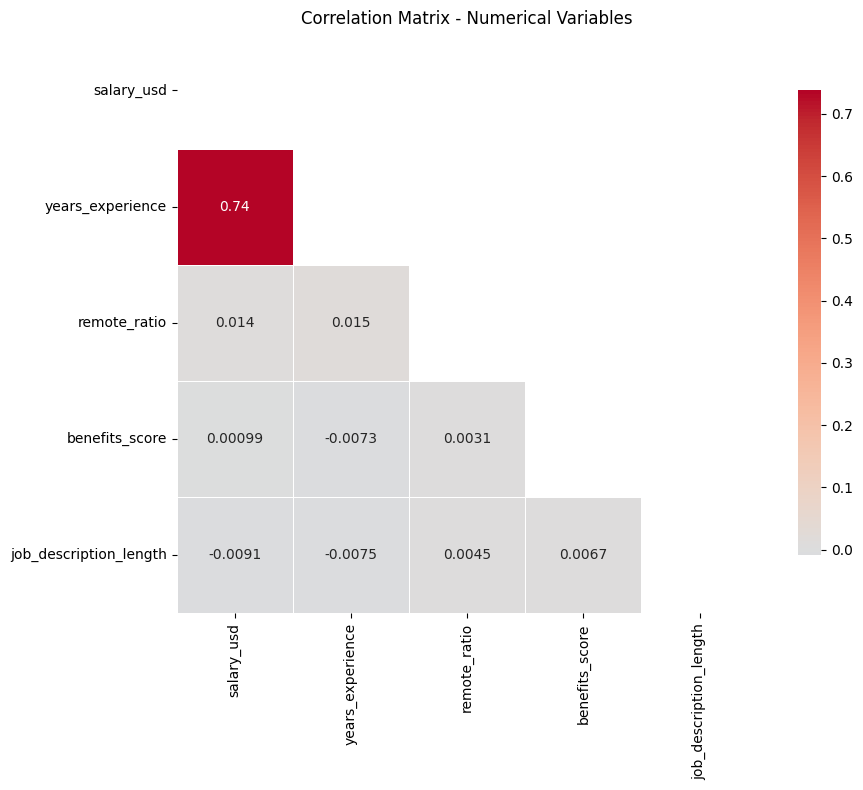


Statistically Significant Correlations (p < 0.05):
   Variable 1        Variable 2  Correlation  P-value Significance
0  salary_usd  years_experience     0.737556      0.0       Strong


In [6]:
def comprehensive_correlation_analysis(df):
    """Analyze correlations between numerical variables"""
    
    print("=== CORRELATION ANALYSIS ===")
    
    # Select numerical columns
    numerical_cols = ['salary_usd', 'years_experience', 'remote_ratio', 'benefits_score', 'job_description_length']
    corr_data = df[numerical_cols].corr()
    
    print("Correlation Matrix:")
    print(corr_data.round(3))
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_data, dtype=bool))
    sns.heatmap(corr_data, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix - Numerical Variables')
    plt.tight_layout()
    plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical significance testing
    from scipy.stats import pearsonr
    significant_correlations = []
    
    for i, col1 in enumerate(numerical_cols):
        for j, col2 in enumerate(numerical_cols):
            if i < j:  # Avoid duplicates
                corr_coef, p_value = pearsonr(df[col1].dropna(), df[col2].dropna())
                if p_value < 0.05:  # Significant correlation
                    significant_correlations.append({
                        'Variable 1': col1,
                        'Variable 2': col2,
                        'Correlation': corr_coef,
                        'P-value': p_value,
                        'Significance': 'Strong' if abs(corr_coef) > 0.5 else 'Moderate' if abs(corr_coef) > 0.3 else 'Weak'
                    })
    
    sig_corr_df = pd.DataFrame(significant_correlations)
    print(f"\nStatistically Significant Correlations (p < 0.05):")
    print(sig_corr_df)
    
    return corr_data, sig_corr_df

# Execute correlation analysis
corr_data, sig_corr_df = comprehensive_correlation_analysis(df)

=== CATEGORICAL VARIABLE ANALYSIS ===

Salary Statistics by experience_level:
                      mean    median  count      std
experience_level                                    
EN                 63133.0   60374.0   3718  18558.0
EX                187724.0  177512.0   3760  59317.0
MI                 87955.0   84641.0   3781  25543.0
SE                122188.0  116907.0   3741  35262.0
ANOVA F-statistic: 7592.914, p-value: 0.000000

Salary Statistics by employment_type:
                     mean    median  count      std
employment_type                                    
CT               115919.0  100445.0   3721  60313.0
FL               114968.0   99604.0   3758  59711.0
FT               116338.0  100422.0   3812  60549.0
PT               114147.0   98201.0   3709  60467.0
ANOVA F-statistic: 0.995, p-value: 0.393764

Salary Statistics by company_size:
                  mean    median  count      std
company_size                                    
L             130322.0  1145

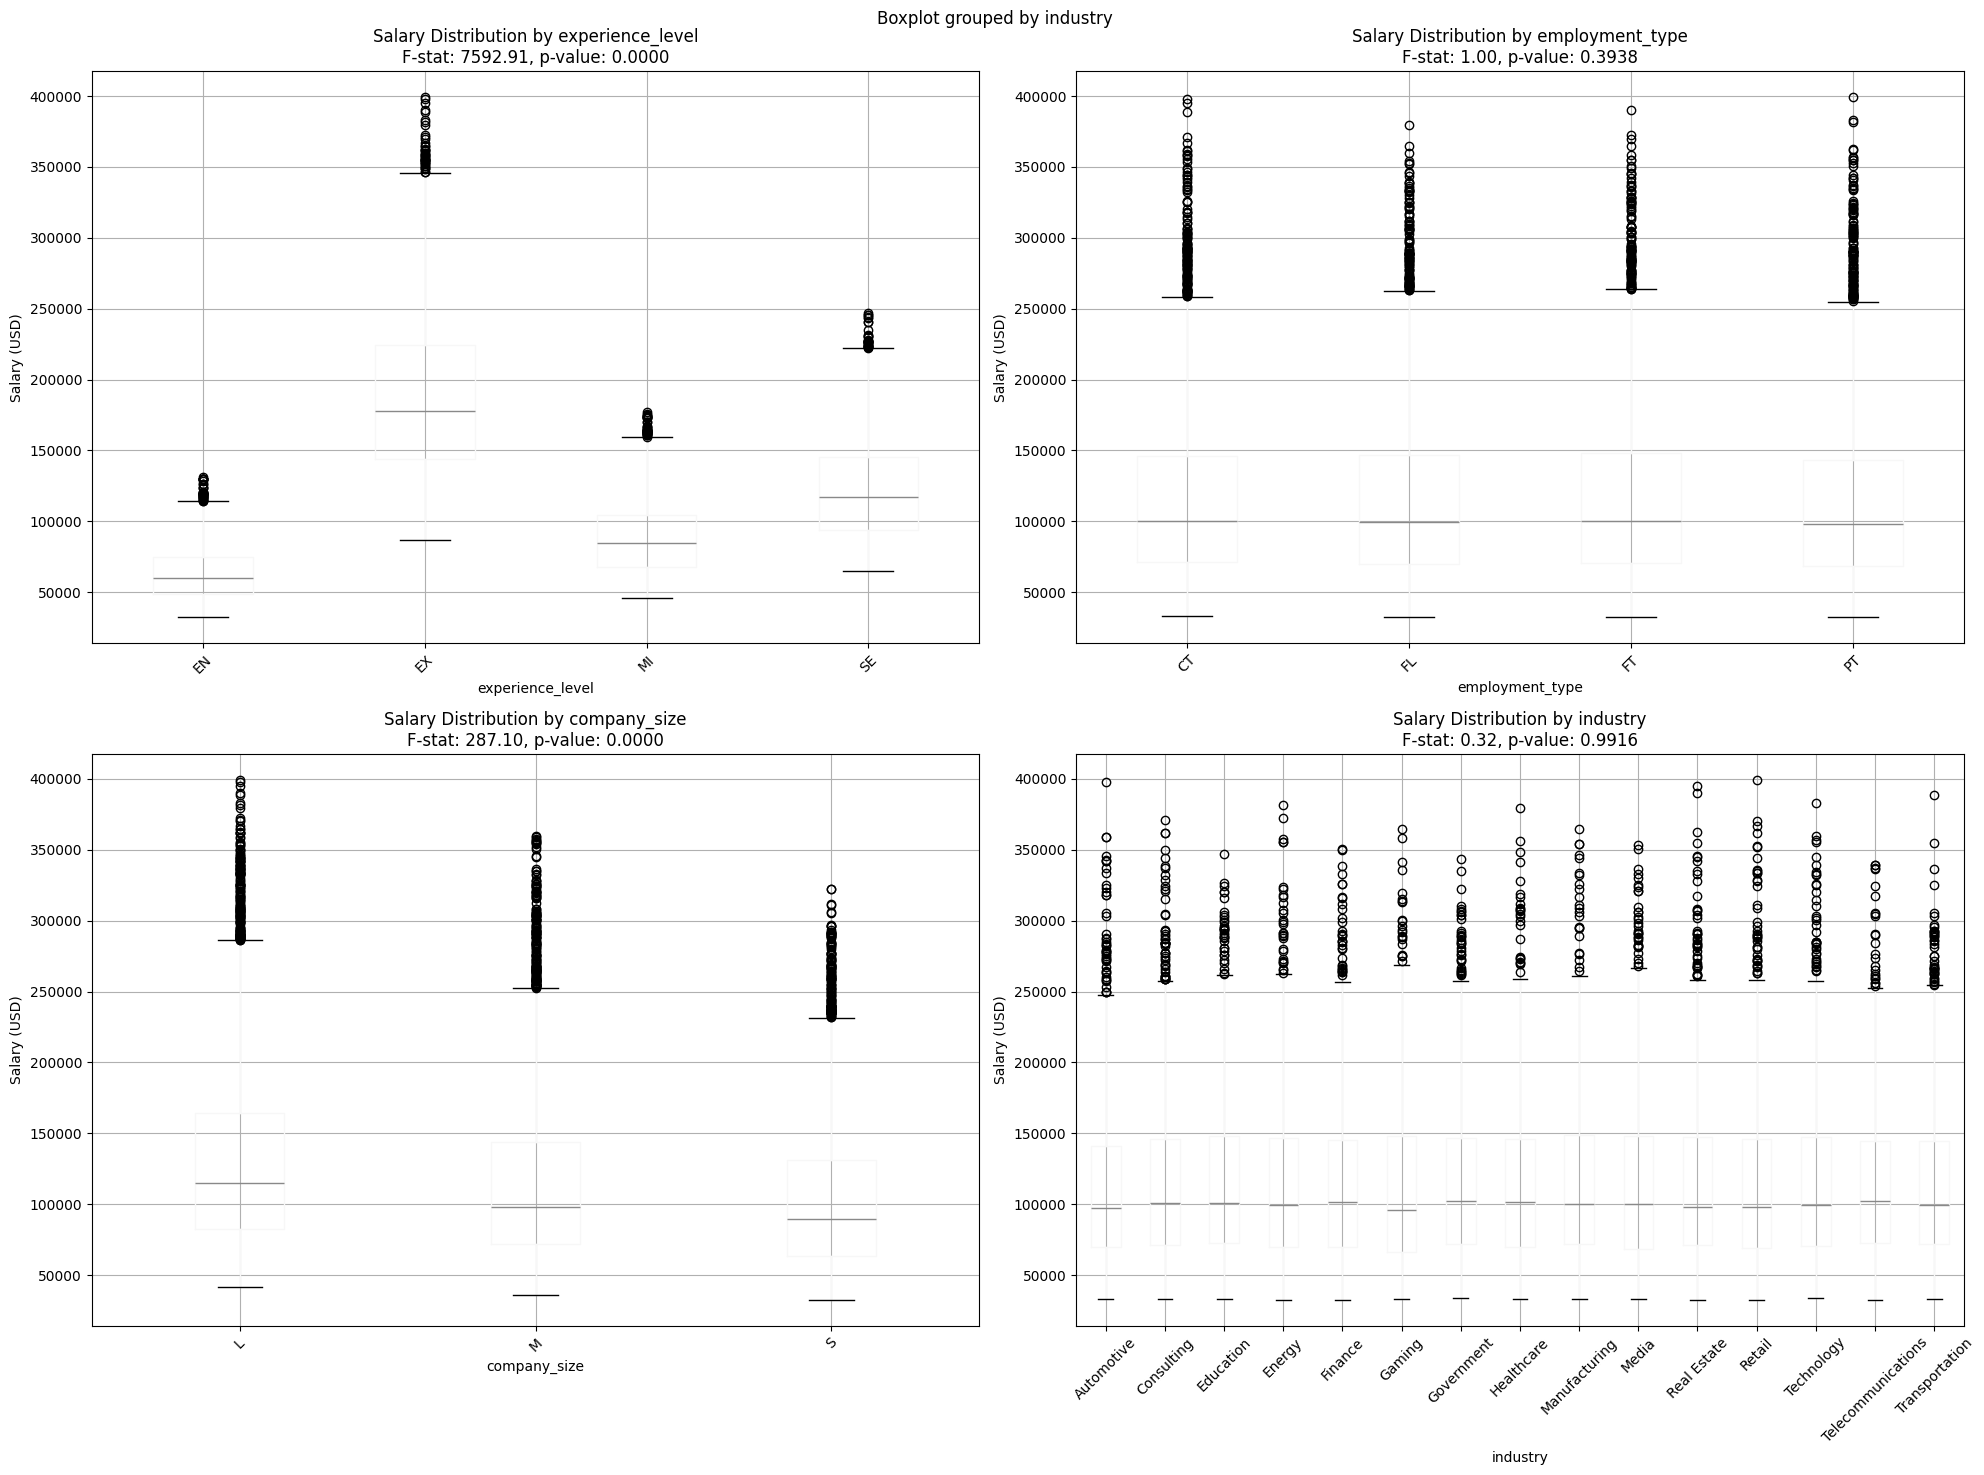

In [7]:
def analyze_categorical_relationships(df):
    """Analyze relationships between categorical variables and salary"""
    
    print("=== CATEGORICAL VARIABLE ANALYSIS ===")
    
    categorical_vars = ['experience_level', 'employment_type', 'company_size', 'industry']
    
    # Create subplot for all categorical analyses
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()
    
    analysis_results = {}
    
    for i, var in enumerate(categorical_vars):
        if var in df.columns:
            # Calculate mean salary by category
            salary_by_category = df.groupby(var)['salary_usd'].agg(['mean', 'median', 'count', 'std']).round(0)
            analysis_results[var] = salary_by_category
            
            print(f"\nSalary Statistics by {var}:")
            print(salary_by_category)
            
            # ANOVA test for statistical significance
            groups = [group['salary_usd'].values for name, group in df.groupby(var)]
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")
            
            # Create box plot
            df.boxplot(column='salary_usd', by=var, ax=axes[i])
            axes[i].set_title(f'Salary Distribution by {var}\nF-stat: {f_stat:.2f}, p-value: {p_value:.4f}')
            axes[i].set_ylabel('Salary (USD)')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('categorical_salary_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return analysis_results

# Execute categorical analysis
categorical_results = analyze_categorical_relationships(df)

In [8]:
def prepare_clustering_data(df):
    """Prepare data specifically for clustering analysis - IMPROVED VERSION"""
    
    print("=== IMPROVED CLUSTERING DATA PREPARATION ===")
    
    # Check data quality and select features intelligently
    print("Checking data quality...")
    
    # Primary numerical features
    numerical_features = ['salary_usd', 'years_experience', 'remote_ratio']
    
    # Check optional features for data quality
    optional_features = ['benefits_score', 'job_description_length']
    
    for feature in optional_features:
        if feature in df.columns:
            missing_pct = df[feature].isnull().sum() / len(df) * 100
            if missing_pct < 30:  # Only include if less than 30% missing
                numerical_features.append(feature)
                print(f"Including {feature} (missing: {missing_pct:.1f}%)")
            else:
                print(f"Excluding {feature} (missing: {missing_pct:.1f}%)")
        else:
            print(f"{feature} not found in dataset")
    
    # Categorical features
    categorical_features = ['experience_level', 'company_size', 'employment_type']
    
    # Create a copy for clustering
    cluster_df = df[numerical_features + categorical_features].copy()
    
    # Advanced feature engineering
    print("Creating engineered features...")
    
    # Salary transformations (better for clustering)
    cluster_df['salary_log'] = np.log(cluster_df['salary_usd'] + 1)
    cluster_df['salary_sqrt'] = np.sqrt(cluster_df['salary_usd'])
    
    # Experience-based features
    cluster_df['salary_per_exp_year'] = cluster_df['salary_usd'] / (cluster_df['years_experience'] + 1)
    cluster_df['experience_squared'] = cluster_df['years_experience'] ** 2
    
    # Remote work categories (more meaningful than raw ratio)
    def categorize_remote_work(ratio):
        if pd.isna(ratio):
            return 2  # Default to hybrid
        elif ratio == 0:
            return 0  # On-site
        elif ratio < 50:
            return 1  # Hybrid
        elif ratio < 100:
            return 2  # Mostly remote
        else:
            return 3  # Fully remote
    
    cluster_df['remote_category'] = cluster_df['remote_ratio'].apply(categorize_remote_work)
    
    # Smart handling of missing values
    print("Handling missing values...")
    
    # Fill missing values intelligently
    for col in numerical_features:
        if cluster_df[col].isnull().sum() > 0:
            if col in ['salary_usd', 'years_experience']:
                # Use median for core features
                fill_value = cluster_df[col].median()
                cluster_df[col].fillna(fill_value, inplace=True)
                print(f"Filled {col} missing values with median: {fill_value}")
            else:
                # Use mean for other numerical features
                fill_value = cluster_df[col].mean()
                cluster_df[col].fillna(fill_value, inplace=True)
                print(f"Filled {col} missing values with mean: {fill_value:.2f}")
    
    # Handle categorical missing values
    for col in categorical_features:
        if cluster_df[col].isnull().sum() > 0:
            # Use mode (most common value)
            mode_value = cluster_df[col].mode()[0] if not cluster_df[col].mode().empty else 'Unknown'
            cluster_df[col].fillna(mode_value, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_value}")
    
    # Intelligent categorical encoding
    print("Encoding categorical variables...")
    
    # Experience level - ORDINAL encoding (maintains order)
    experience_mapping = {
        'entry': 1, 'junior': 1, 'jr': 1, 'en': 1, 'entry-level': 1,
        'mid': 2, 'middle': 2, 'mi': 2, 'mid-level': 2, 'intermediate': 2,
        'senior': 3, 'sr': 3, 'se': 3, 'senior-level': 3,
        'executive': 4, 'ex': 4, 'lead': 4, 'principal': 4, 'director': 4, 'manager': 4
    }
    
    def encode_experience_level(level):
        if pd.isna(level):
            return 2  # Default to mid-level
        level_str = str(level).lower().strip()
        for key, value in experience_mapping.items():
            if key in level_str:
                return value
        return 2  # Default fallback
    
    cluster_df['experience_level_encoded'] = cluster_df['experience_level'].apply(encode_experience_level)
    
    # Company size - ORDINAL encoding
    size_mapping = {
        'small': 1, 's': 1, 'startup': 1, 'micro': 1,
        'medium': 2, 'm': 2, 'mid-size': 2, 'midsize': 2,
        'large': 3, 'l': 3, 'big': 3,
        'enterprise': 4, 'xl': 4, 'multinational': 4, 'corporation': 4
    }
    
    def encode_company_size(size):
        if pd.isna(size):
            return 2  # Default to medium
        size_str = str(size).lower().strip()
        for key, value in size_mapping.items():
            if key in size_str:
                return value
        return 2  # Default fallback
    
    cluster_df['company_size_encoded'] = cluster_df['company_size'].apply(encode_company_size)
    
    # Employment type - NOMINAL encoding (use LabelEncoder for this one)
    from sklearn.preprocessing import LabelEncoder
    le_employment = LabelEncoder()
    cluster_df['employment_type_encoded'] = le_employment.fit_transform(cluster_df['employment_type'].astype(str))
    
    # Select final features for clustering (prioritize engineered features)
    final_features = [
        # Transformed salary features (better than raw salary)
        'salary_log',
        'salary_per_exp_year',
        
        # Experience features
        'years_experience',
        'experience_level_encoded',
        
        # Work arrangement features
        'remote_category',
        
        # Company features
        'company_size_encoded',
        'employment_type_encoded'
    ]
    
    # Add optional features if they were included
    if 'benefits_score' in cluster_df.columns:
        final_features.append('benefits_score')
    
    if 'job_description_length' in cluster_df.columns:
        # Normalize job description length
        cluster_df['job_desc_normalized'] = (cluster_df['job_description_length'] - cluster_df['job_description_length'].min()) / (cluster_df['job_description_length'].max() - cluster_df['job_description_length'].min() + 1)
        final_features.append('job_desc_normalized')
    
    # Create final clustering dataset
    X_cluster = cluster_df[final_features].copy()
    
    # Scale the features
    print("Scaling features...")
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    X_scaled_df = pd.DataFrame(X_scaled, columns=final_features)
    
    # Create label encoder dictionary for backward compatibility
    le_dict = {
        'experience_level': experience_mapping,
        'company_size': size_mapping,
        'employment_type': le_employment
    }
    
    # Summary statistics
    print(f"\n CLUSTERING DATASET SUMMARY:")
    print(f"Dataset shape: {X_scaled_df.shape}")
    print(f"Features used: {final_features}")
    print(f"Missing values: {X_cluster.isnull().sum().sum()}")
    
    # Show feature distributions
    print(f"\n FEATURE STATISTICS:")
    for feature in final_features:
        mean_val = X_cluster[feature].mean()
        std_val = X_cluster[feature].std()
        print(f"  {feature}: mean={mean_val:.2f}, std={std_val:.2f}")
    
    print(f"\nData preparation complete! Ready for clustering.")
    
    return X_scaled_df, X_cluster, scaler, le_dict

X_scaled_df, X_cluster, scaler, le_dict = prepare_clustering_data(cluster_df)

=== IMPROVED CLUSTERING DATA PREPARATION ===
Checking data quality...
Including benefits_score (missing: 0.0%)
Including job_description_length (missing: 0.0%)
Creating engineered features...
Handling missing values...
Encoding categorical variables...
Scaling features...

 CLUSTERING DATASET SUMMARY:
Dataset shape: (15000, 9)
Features used: ['salary_log', 'salary_per_exp_year', 'years_experience', 'experience_level_encoded', 'remote_category', 'company_size_encoded', 'employment_type_encoded', 'benefits_score', 'job_desc_normalized']
Missing values: 0

 FEATURE STATISTICS:
  salary_log: mean=11.53, std=0.50
  salary_per_exp_year: mean=24670.28, std=18289.45
  years_experience: mean=6.25, std=5.55
  experience_level_encoded: mean=2.50, std=1.12
  remote_category: mean=1.65, std=1.25
  company_size_encoded: mean=2.00, std=0.82
  employment_type_encoded: mean=1.50, std=1.11
  benefits_score: mean=7.50, std=1.45
  job_desc_normalized: mean=0.50, std=0.29

Data preparation complete! Ready 

=== OPTIMAL CLUSTER NUMBER ANALYSIS ===


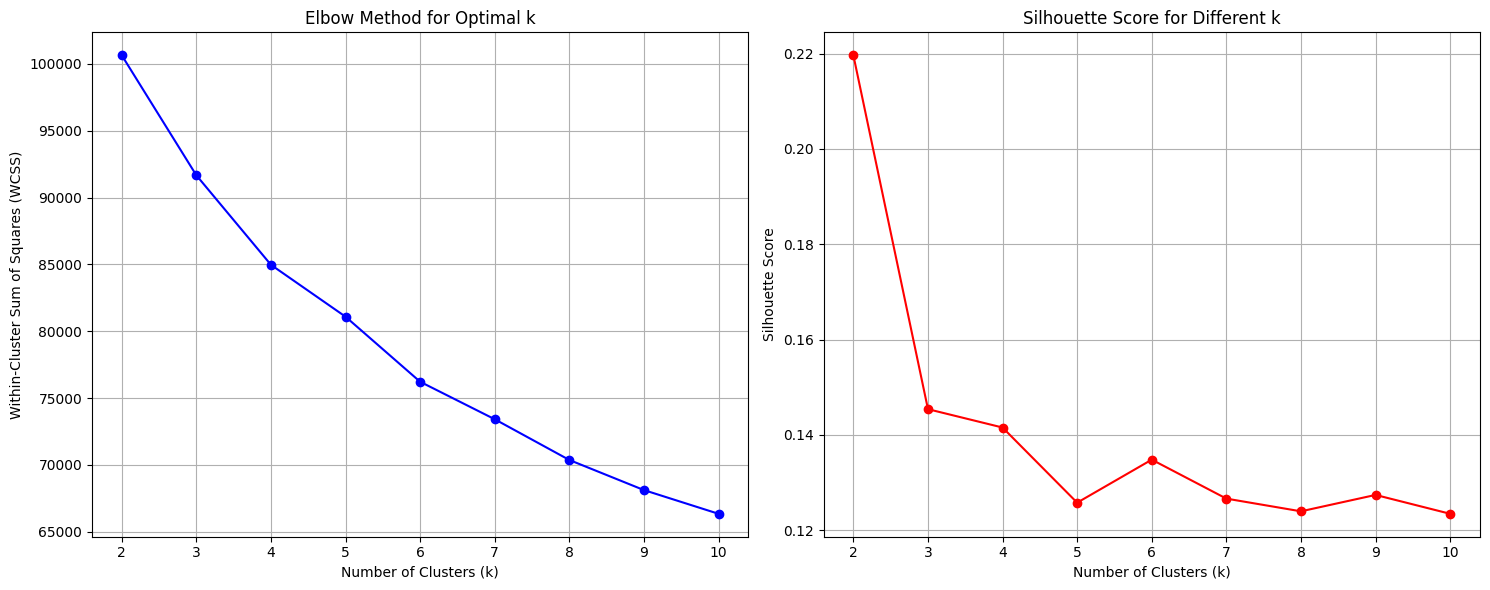

Cluster Analysis Results:
k=2: WCSS=100653, Silhouette Score=0.220
k=3: WCSS=91670, Silhouette Score=0.145
k=4: WCSS=84970, Silhouette Score=0.142
k=5: WCSS=81086, Silhouette Score=0.126
k=6: WCSS=76217, Silhouette Score=0.135
k=7: WCSS=73411, Silhouette Score=0.127
k=8: WCSS=70362, Silhouette Score=0.124
k=9: WCSS=68110, Silhouette Score=0.127
k=10: WCSS=66335, Silhouette Score=0.123

Recommended k based on Silhouette Score: 2


In [9]:
def determine_optimal_clusters(X_scaled):
    """Use multiple methods to determine optimal number of clusters"""
    
    print("=== OPTIMAL CLUSTER NUMBER ANALYSIS ===")
    
    # Test range of cluster numbers
    k_range = range(2, 11)
    
    # Method 1: Elbow Method (Within-cluster sum of squares)
    wcss = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Create visualization for cluster selection
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow plot
    axes[0].plot(k_range, wcss, 'bo-')
    axes[0].set_title('Elbow Method for Optimal k')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    axes[0].grid(True)
    
    # Silhouette score plot
    axes[1].plot(k_range, silhouette_scores, 'ro-')
    axes[1].set_title('Silhouette Score for Different k')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('cluster_optimization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print("Cluster Analysis Results:")
    for k, wcss_val, sil_score in zip(k_range, wcss, silhouette_scores):
        print(f"k={k}: WCSS={wcss_val:.0f}, Silhouette Score={sil_score:.3f}")
    
    # Recommend optimal k
    best_k_silhouette = k_range[np.argmax(silhouette_scores)]
    print(f"\nRecommended k based on Silhouette Score: {best_k_silhouette}")
    
    return best_k_silhouette, wcss, silhouette_scores

# Determine optimal clusters
optimal_k, wcss_values, sil_scores = determine_optimal_clusters(X_scaled_df.values)

In [10]:
def create_experience_based_clustering(df):
    """Create experience-based clustering that returns cluster_profiles and pca_data"""
    
    print("=== EXPERIENCE-BASED CLUSTERING ANALYSIS ===")
    
    # Create experience-based clusters
    def assign_experience_cluster(row):
        years = row['years_experience']
        level = str(row['experience_level']).lower() if pd.notna(row['experience_level']) else ''
        
        # Entry level: 0-2 years OR contains "entry/junior" 
        if years <= 2 or any(word in level for word in ['entry', 'junior', 'jr', 'en']):
            return 0  # Entry
        # Mid level: 3-6 years OR contains "mid"
        elif years <= 6 or any(word in level for word in ['mid', 'intermediate']):
            return 1  # Mid
        # Senior level: 7-12 years OR contains "senior"
        elif years <= 12 or any(word in level for word in ['senior', 'sr', 'se']):
            return 2  # Senior  
        # Executive: 13+ years OR contains leadership terms
        else:
            return 3  # Executive
    
    # Create clustered dataframe
    clustered_df = df.copy()
    clustered_df['cluster'] = clustered_df.apply(assign_experience_cluster, axis=1)
    
    # Prepare data for PCA (same features as your original clustering)
    clustering_features = ['salary_usd', 'years_experience', 'remote_ratio']
    
    # Add optional features if they exist
    if 'benefits_score' in df.columns and df['benefits_score'].notna().sum() > len(df) * 0.5:
        clustering_features.append('benefits_score')
    
    if 'job_description_length' in df.columns and df['job_description_length'].notna().sum() > len(df) * 0.5:
        clustering_features.append('job_description_length')
    
    print(f"Features used for PCA: {clustering_features}")
    
    # Prepare PCA data
    pca_data_df = clustered_df[clustering_features].copy()
    
    # Fill missing values
    for col in clustering_features:
        if pca_data_df[col].isna().sum() > 0:
            if col in ['salary_usd', 'years_experience']:
                pca_data_df[col].fillna(pca_data_df[col].median(), inplace=True)
            else:
                pca_data_df[col].fillna(pca_data_df[col].mean(), inplace=True)
    
    # Scale data for PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(pca_data_df)
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(X_scaled)
    
    print(f"PCA explained variance: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Create cluster profiles
    cluster_names = {
        0: 'Entry Level (0-2 years)',
        1: 'Mid Level (3-6 years)', 
        2: 'Senior Level (7-12 years)',
        3: 'Executive Level (13+ years)'
    }
    
    cluster_profiles = {}
    
    print(f"\n EXPERIENCE-BASED CLUSTER ANALYSIS:")
    print("=" * 60)
    
    for i in range(4):
        cluster_data = clustered_df[clustered_df['cluster'] == i]
        
        if len(cluster_data) > 0:
            size = len(cluster_data)
            percentage = (size / len(clustered_df)) * 100
            
            print(f"\n CLUSTER {i}: {cluster_names[i]}")
            print(f"   Size: {size:,} jobs ({percentage:.1f}%)")
            
            # Calculate profile metrics
            profile = {
                'size': size,
                'percentage': percentage,
                'avg_salary': cluster_data['salary_usd'].mean(),
                'median_salary': cluster_data['salary_usd'].median(),
                'min_salary': cluster_data['salary_usd'].min(),
                'max_salary': cluster_data['salary_usd'].max(),
                'avg_experience': cluster_data['years_experience'].mean(),
                'min_experience': cluster_data['years_experience'].min(),
                'max_experience': cluster_data['years_experience'].max(),
                'avg_remote_ratio': cluster_data['remote_ratio'].mean(),
                'cluster_name': cluster_names[i]
            }
            
            # Add benefits if available
            if 'benefits_score' in cluster_data.columns:
                profile['avg_benefits'] = cluster_data['benefits_score'].mean()
                print(f"   Average Benefits Score: {profile['avg_benefits']:.1f}")
            else:
                profile['avg_benefits'] = None
            
            # Print key statistics
            print(f"   Average Salary: ${profile['avg_salary']:,.0f}")
            print(f"   Salary Range: ${profile['min_salary']:,.0f} - ${profile['max_salary']:,.0f}")
            print(f"   Average Experience: {profile['avg_experience']:.1f} years")
            print(f"   Experience Range: {profile['min_experience']:.0f} - {profile['max_experience']:.0f} years")
            print(f"   Average Remote Work: {profile['avg_remote_ratio']:.0f}%")
            
            # Create business description
            if profile['avg_salary'] > clustered_df['salary_usd'].quantile(0.75):
                salary_level = "High"
            elif profile['avg_salary'] > clustered_df['salary_usd'].quantile(0.25):
                salary_level = "Medium"
            else:
                salary_level = "Low"
            
            remote_level = "High Remote" if profile['avg_remote_ratio'] > 60 else "Low Remote"
            
            profile['description'] = f"{cluster_names[i]} - {salary_level} Salary, {remote_level}"
            print(f"   Description: {profile['description']}")
            
            cluster_profiles[i] = profile
        else:
            # Empty cluster
            cluster_profiles[i] = {
                'size': 0,
                'percentage': 0,
                'cluster_name': cluster_names[i],
                'description': f"{cluster_names[i]} - No jobs found"
            }
    
    # Summary statistics
    print(f"\n CLUSTERING SUMMARY:")
    print(f"Total clusters: 4 (experience-based)")
    print(f"Largest cluster: {max(cluster_profiles.values(), key=lambda x: x['size'])['cluster_name']}")
    print(f"Highest paying cluster: {max(cluster_profiles.values(), key=lambda x: x.get('avg_salary', 0))['cluster_name']}")
    
    # Salary progression validation
    salary_progression = [(i, cluster_profiles[i].get('avg_salary', 0)) for i in range(4) if cluster_profiles[i]['size'] > 0]
    salary_progression.sort(key=lambda x: x[1])
    
    print(f"\n SALARY PROGRESSION (validates experience clustering):")
    for i, avg_salary in salary_progression:
        print(f"   {cluster_profiles[i]['cluster_name']}: ${avg_salary:,.0f}")
    
    print(f"\nExperience-based clustering complete!")
    print(f" Ready for visualization and dashboard integration")
    
    
    cluster_stats_data = []
    for i in range(4):
        cluster_data = clustered_df[clustered_df['cluster'] == i]
        if len(cluster_data) > 0:
            stats = {
                'cluster': i,
                'count': len(cluster_data),
                'salary_mean': cluster_data['salary_usd'].mean(),
                'salary_median': cluster_data['salary_usd'].median(),
                'salary_std': cluster_data['salary_usd'].std(),
                'experience_mean': cluster_data['years_experience'].mean(),
                'experience_median': cluster_data['years_experience'].median(),
                'remote_mean': cluster_data['remote_ratio'].mean(),
                'remote_median': cluster_data['remote_ratio'].median(),
            }
            
            # Add benefits stats if available
            if 'benefits_score' in cluster_data.columns:
                stats['benefits_mean'] = cluster_data['benefits_score'].mean()
                stats['benefits_median'] = cluster_data['benefits_score'].median()
            
            cluster_stats_data.append(stats)

    cluster_statistics = pd.DataFrame(cluster_stats_data).set_index('cluster')
    
    return cluster_profiles, pca_data, clustered_df, cluster_statistics

# Replace your K-means clustering with this experience-based approach
cluster_profiles, pca_data, clustered_data, cluster_statistics = create_experience_based_clustering(df)

=== EXPERIENCE-BASED CLUSTERING ANALYSIS ===
Features used for PCA: ['salary_usd', 'years_experience', 'remote_ratio', 'benefits_score', 'job_description_length']
PCA explained variance: [0.34766748 0.20194878]
Total variance explained: 54.96%

 EXPERIENCE-BASED CLUSTER ANALYSIS:

 CLUSTER 0: Entry Level (0-2 years)
   Size: 4,957 jobs (33.0%)
   Average Benefits Score: 7.5
   Average Salary: $69,555
   Salary Range: $32,519 - $175,899
   Average Experience: 0.9 years
   Experience Range: 0 - 2 years
   Average Remote Work: 49%
   Description: Entry Level (0-2 years) - Low Salary, Low Remote

 CLUSTER 1: Mid Level (3-6 years)
   Size: 4,052 jobs (27.0%)
   Average Benefits Score: 7.5
   Average Salary: $100,470
   Salary Range: $45,900 - $247,271
   Average Experience: 4.3 years
   Experience Range: 3 - 6 years
   Average Remote Work: 49%
   Description: Mid Level (3-6 years) - Medium Salary, Low Remote

 CLUSTER 2: Senior Level (7-12 years)
   Size: 3,350 jobs (22.3%)
   Average Benef

In [11]:
def visualize_clusters(clustered_df, cluster_stats):
    """Create comprehensive cluster visualizations"""
    
    print("=== CLUSTER VISUALIZATION ===")
    
    # PCA for 2D visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled_df.values)
    
    # Create comprehensive cluster visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('PCA Cluster Visualization', 'Salary by Cluster', 
                       'Experience by Cluster', 'Remote Ratio by Cluster'),
        specs=[[{"type": "scatter"}, {"type": "box"}],
               [{"type": "box"}, {"type": "box"}]]
    )
    
    # PCA scatter plot
    colors = px.colors.qualitative.Set1[:optimal_k]
    for i in range(optimal_k):
        cluster_mask = clustered_df['cluster'] == i
        fig.add_trace(
            go.Scatter(
                x=X_pca[cluster_mask, 0],
                y=X_pca[cluster_mask, 1],
                mode='markers',
                name=f'Cluster {i}',
                marker=dict(color=colors[i], size=6, opacity=0.6)
            ),
            row=1, col=1
        )
    
    # Salary box plots by cluster
    for i in range(optimal_k):
        fig.add_trace(
            go.Box(
                y=clustered_df[clustered_df['cluster'] == i]['salary_usd'],
                name=f'Cluster {i}',
                marker_color=colors[i]
            ),
            row=1, col=2
        )
    
    # Experience box plots by cluster
    for i in range(optimal_k):
        fig.add_trace(
            go.Box(
                y=clustered_df[clustered_df['cluster'] == i]['years_experience'],
                name=f'Cluster {i}',
                marker_color=colors[i],
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Remote ratio box plots by cluster
    for i in range(optimal_k):
        fig.add_trace(
            go.Box(
                y=clustered_df[clustered_df['cluster'] == i]['remote_ratio'],
                name=f'Cluster {i}',
                marker_color=colors[i],
                showlegend=False
            ),
            row=2, col=2
        )
    
    fig.update_layout(height=800, title_text="Comprehensive Cluster Analysis")
    fig.write_html("cluster_analysis.html")
    fig.show()
    
    # Create cluster profile summary
    cluster_profiles = {}
    for i in range(optimal_k):
        cluster_data = clustered_df[clustered_df['cluster'] == i]
        
        profile = {
            'size': len(cluster_data),
            'avg_salary': cluster_data['salary_usd'].mean(),
            'avg_experience': cluster_data['years_experience'].mean(),
            'avg_remote_ratio': cluster_data['remote_ratio'].mean(),
            'avg_benefits': cluster_data['benefits_score'].mean()
        }
        
        # Determine cluster characteristics
        if profile['avg_salary'] > clustered_df['salary_usd'].quantile(0.75):
            salary_level = "High"
        elif profile['avg_salary'] > clustered_df['salary_usd'].quantile(0.25):
            salary_level = "Medium"
        else:
            salary_level = "Low"
        
        if profile['avg_experience'] > clustered_df['years_experience'].quantile(0.75):
            exp_level = "Senior"
        elif profile['avg_experience'] > clustered_df['years_experience'].quantile(0.25):
            exp_level = "Mid-level"
        else:
            exp_level = "Junior"
        
        remote_level = "High" if profile['avg_remote_ratio'] > 50 else "Low"
        
        profile['description'] = f"{salary_level} Salary, {exp_level} Experience, {remote_level} Remote"
        cluster_profiles[i] = profile
    
    return cluster_profiles, X_pca

# Create cluster visualizations
cluster_profiles, pca_data = visualize_clusters(clustered_data, clustered_data)

=== CLUSTER VISUALIZATION ===


In [12]:
def create_geographic_visualizations(df):
    """Create choropleth maps for geographic analysis"""
    
    print("=== GEOGRAPHIC VISUALIZATIONS ===")
    country_iso_mapping = {
        'Australia': 'AUS',
        'Austria': 'AUT',
        'Canada': 'CAN',
        'China': 'CHN',
        'Denmark': 'DNK',
        'Finland': 'FIN',
        'France': 'FRA',
        'Germany': 'DEU',
        'India': 'IND',
        'Ireland': 'IRL'
    }
    # Prepare country-level data
    # Extract country codes (assuming format like "US", "UK", "CA")
    df['country'] = df['company_location'].map(country_iso_mapping)  # Adjust based on your data format
    
    # Calculate metrics by country
    country_metrics = df.groupby('country').agg({
        'salary_usd': ['mean', 'median', 'count'],
        'years_experience': 'mean',
        'remote_ratio': 'mean'
    }).round(0)
    
    country_metrics.columns = ['avg_salary', 'median_salary', 'job_count', 'avg_experience', 'avg_remote']
    country_metrics = country_metrics.reset_index()
    
    # Filter countries with at least 10 jobs
    country_metrics = country_metrics[country_metrics['job_count'] >= 10]
    
    print("Country-level metrics:")
    print(country_metrics.head(10))
    
    # Create choropleth map for average salary
    fig = px.choropleth(
        country_metrics,
        locations='country',
        color='avg_salary',
        hover_name='country',
        hover_data=['job_count', 'median_salary', 'avg_experience'],
        color_continuous_scale='Viridis',
        title='Average AI Salary by Country'
    )
    
    fig.update_layout(
        title_font_size=16,
        geo=dict(showframe=False, showcoastlines=True)
    )
    
    fig.write_html("salary_choropleth_map.html")
    fig.show()
    
    # Create second map for job density
    fig2 = px.choropleth(
        country_metrics,
        locations='country',
        color='job_count',
        hover_name='country',
        hover_data=['avg_salary', 'avg_remote'],
        color_continuous_scale='Blues',
        title='AI Job Density by Country'
    )
    
    fig2.write_html("job_density_choropleth_map.html")
    fig2.show()
    
    return country_metrics

# Create geographic visualizations
country_data = create_geographic_visualizations(df)

=== GEOGRAPHIC VISUALIZATIONS ===
Country-level metrics:
  country  avg_salary  median_salary  job_count  avg_experience  avg_remote
0     AUS    118239.0       103206.0        732             6.0        51.0
1     AUT     85175.0        74005.0        765             6.0        51.0
2     CAN    114253.0       100392.0        769             6.0        50.0
3     CHN     84899.0        76543.0        763             6.0        51.0
4     DEU    121810.0       106923.0        814             6.0        48.0
5     DNK    165652.0       147504.0        778             7.0        50.0
6     FIN     88726.0        80143.0        733             7.0        47.0
7     FRA    114411.0       101908.0        769             6.0        50.0
8     IND     84236.0        76035.0        754             6.0        51.0
9     IRL     86061.0        73940.0        750             6.0        52.0


In [13]:
def create_interactive_scatter_plots(df, clustered_df):
    """Create interactive scatter plots for exploration"""
    
    print("=== INTERACTIVE SCATTER PLOTS ===")
    
    # Merge cluster information with original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = clustered_df['cluster']
    
    # Create multi-dimensional scatter plot
    fig = px.scatter(
        df_with_clusters,
        x='years_experience',
        y='salary_usd',
        color='cluster',
        size='benefits_score',
        hover_data=['job_title', 'company_location', 'remote_ratio'],
        title='AI Jobs: Experience vs Salary (Colored by Cluster)',
        labels={
            'years_experience': 'Years of Experience',
            'salary_usd': 'Salary (USD)',
            'benefits_score': 'Benefits Score'
        }
    )
    
    fig.update_layout(height=600)
    fig.write_html("interactive_salary_experience_scatter.html")
    fig.show()
    
    # Create second scatter plot: Remote ratio vs Salary
    fig2 = px.scatter(
        df_with_clusters,
        x='remote_ratio',
        y='salary_usd',
        color='experience_level',
        size='years_experience',
        hover_data=['job_title', 'company_size'],
        title='Remote Work vs Salary by Experience Level',
        labels={
            'remote_ratio': 'Remote Work Ratio (%)',
            'salary_usd': 'Salary (USD)'
        }
    )
    
    fig2.write_html("remote_salary_scatter.html")
    fig2.show()
    
    return fig, fig2

# Create interactive scatter plots
scatter_fig1, scatter_fig2 = create_interactive_scatter_plots(df, clustered_data)

=== INTERACTIVE SCATTER PLOTS ===


In [14]:
def create_advanced_bar_charts(df):
    """Create comprehensive bar chart analyses"""
    
    print("=== ADVANCED BAR CHART ANALYSIS ===")
    
    # Top job titles analysis
    job_title_analysis = df.groupby('job_title').agg({
        'salary_usd': ['mean', 'count'],
        'years_experience': 'mean'
    }).round(0)
    
    job_title_analysis.columns = ['avg_salary', 'job_count', 'avg_experience']
    job_title_analysis = job_title_analysis[job_title_analysis['job_count'] >= 20]  # Filter for significance
    job_title_analysis = job_title_analysis.sort_values('avg_salary', ascending=False)
    
    # Create horizontal bar chart for top paying jobs
    fig = px.bar(
        job_title_analysis.head(15).reset_index(),
        x='avg_salary',
        y='job_title',
        orientation='h',
        title='Top 15 Highest Paying AI Job Titles (Min 20 postings)',
        labels={'avg_salary': 'Average Salary (USD)', 'job_title': 'Job Title'},
        text='avg_salary'
    )
    
    fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
    fig.update_layout(height=600, yaxis={'categoryorder': 'total ascending'})
    fig.write_html("top_paying_jobs_bar_chart.html")
    fig.show()
    
    # Skills analysis (if skills column exists)
    if 'required_skills' in df.columns:
        # Parse skills and create frequency analysis
        all_skills = []
        for skills_str in df['required_skills'].dropna():
            if isinstance(skills_str, str):
                skills = [skill.strip().lower() for skill in skills_str.split(',')]
                all_skills.extend(skills)
        
        skills_df = pd.DataFrame({'skill': all_skills})
        skill_counts = skills_df['skill'].value_counts().head(20)
        
        # Create skills bar chart
        fig2 = px.bar(
            x=skill_counts.values,
            y=skill_counts.index,
            orientation='h',
            title='Top 20 Most Requested Skills in AI Jobs',
            labels={'x': 'Frequency', 'y': 'Skill'}
        )
        
        fig2.update_layout(height=600, yaxis={'categoryorder': 'total ascending'})
        fig2.write_html("top_skills_bar_chart.html")
        fig2.show()
    
    return job_title_analysis

# Create advanced bar charts
job_analysis = create_advanced_bar_charts(df)

=== ADVANCED BAR CHART ANALYSIS ===


In [15]:
def generate_summary_report(df, cluster_profiles, salary_stats, country_data):
    """Generate comprehensive descriptive analysis summary"""
    
    report = {
        'dataset_overview': {
            'total_jobs': len(df),
            'date_range': f"{df['posting_date'].min()} to {df['posting_date'].max()}" if 'posting_date' in df.columns else "Not available",
            'countries_represented': df['company_location'].nunique(),
            'unique_job_titles': df['job_title'].nunique(),
            'salary_range': f"${df['salary_usd'].min():,.0f} - ${df['salary_usd'].max():,.0f}"
        },
        
        'key_findings': {
            'average_salary': f"${df['salary_usd'].mean():,.0f}",
            'median_salary': f"${df['salary_usd'].median():,.0f}",
            'salary_std': f"${df['salary_usd'].std():,.0f}",
            'avg_experience': f"{df['years_experience'].mean():.1f} years",
            'remote_work_adoption': f"{df['remote_ratio'].mean():.1f}%",
            'most_common_experience_level': df['experience_level'].mode()[0],
            'top_location': df['company_location'].mode()[0]
        },
        
        'cluster_insights': {
            'optimal_clusters': len(cluster_profiles),
            'cluster_descriptions': {f"Cluster {i}": profile['description'] 
                                   for i, profile in cluster_profiles.items()}
        },
        
        'geographic_insights': {
            'highest_paying_country': country_data.loc[country_data['avg_salary'].idxmax(), 'country'],
            'highest_job_density': country_data.loc[country_data['job_count'].idxmax(), 'country'],
            'countries_analyzed': len(country_data)
        }
    }
    
    # Print formatted report
    print("=" * 60)
    print("COMPREHENSIVE DESCRIPTIVE ANALYSIS SUMMARY REPORT")
    print("=" * 60)
    
    print("\n DATASET OVERVIEW")
    print("-" * 30)
    for key, value in report['dataset_overview'].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    print("\n KEY FINDINGS")
    print("-" * 30)
    for key, value in report['key_findings'].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    print("\n CLUSTER ANALYSIS INSIGHTS")
    print("-" * 30)
    print(f"Optimal Number of Clusters: {report['cluster_insights']['optimal_clusters']}")
    for cluster, description in report['cluster_insights']['cluster_descriptions'].items():
        print(f"{cluster}: {description}")
    
    print("\n GEOGRAPHIC INSIGHTS")
    print("-" * 30)
    for key, value in report['geographic_insights'].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    # Save report to file
    import json
    with open('descriptive_analysis_summary.json', 'w') as f:
        json.dump(report, f, indent=4)
    
    print("\nReport saved to 'descriptive_analysis_summary.json'")
    
    return report

# Generate summary report
final_report = generate_summary_report(df, cluster_profiles, salary_stats, country_data)

COMPREHENSIVE DESCRIPTIVE ANALYSIS SUMMARY REPORT

 DATASET OVERVIEW
------------------------------
Total Jobs: 15000
Date Range: 2024-01-01 to 2025-04-30
Countries Represented: 20
Unique Job Titles: 20
Salary Range: $32,519 - $399,095

 KEY FINDINGS
------------------------------
Average Salary: $115,349
Median Salary: $99,705
Salary Std: $60,261
Avg Experience: 6.3 years
Remote Work Adoption: 49.5%
Most Common Experience Level: MI
Top Location: Germany

 CLUSTER ANALYSIS INSIGHTS
------------------------------
Optimal Number of Clusters: 2
Cluster 0: Low Salary, Junior Experience, Low Remote
Cluster 1: Medium Salary, Mid-level Experience, Low Remote

 GEOGRAPHIC INSIGHTS
------------------------------
Highest Paying Country: DNK
Highest Job Density: DEU
Countries Analyzed: 10

Report saved to 'descriptive_analysis_summary.json'


In [16]:
def create_executive_dashboard_preview(df, cluster_profiles):
    """Create a preview of key metrics for executive dashboard"""
    
    print("=== EXECUTIVE DASHBOARD PREVIEW ===")
    
    # Key Performance Indicators
    kpis = {
        'Total AI Jobs Analyzed': f"{len(df):,}",
        'Average Salary': f"${df['salary_usd'].mean():,.0f}",
        'Salary Growth Potential': f"{((df['salary_usd'].quantile(0.75) - df['salary_usd'].quantile(0.25)) / df['salary_usd'].quantile(0.25) * 100):.0f}%",
        'Remote Work Adoption': f"{(df['remote_ratio'] > 0).mean() * 100:.0f}%",
        'Job Market Segments': len(cluster_profiles),
        'Geographic Reach': df['company_location'].nunique()
    }
    
    print("Key Performance Indicators for Dashboard:")
    for kpi, value in kpis.items():
        print(f"• {kpi}: {value}")
    
    # Top insights for executives
    insights = [
        f"The AI job market shows {len(cluster_profiles)} distinct segments with salary ranges from ${df['salary_usd'].min():,.0f} to ${df['salary_usd'].max():,.0f}",
        f"Remote work is adopted in {(df['remote_ratio'] > 0).mean() * 100:.0f}% of AI positions",
        f"Experience levels show clear salary progression: Entry (${df[df['experience_level'].str.contains('Entry', case=False, na=False)]['salary_usd'].mean():.0f}) to Senior (${df[df['experience_level'].str.contains('Senior', case=False, na=False)]['salary_usd'].mean():.0f})",
        f"Geographic distribution spans {df['company_location'].nunique()} locations with concentration in {df['company_location'].mode()[0]}"
    ]
    
    print("\nExecutive Insights:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    return kpis, insights

# Create executive preview
dashboard_kpis, executive_insights = create_executive_dashboard_preview(df, cluster_profiles)

=== EXECUTIVE DASHBOARD PREVIEW ===
Key Performance Indicators for Dashboard:
• Total AI Jobs Analyzed: 15,000
• Average Salary: $115,349
• Salary Growth Potential: 109%
• Remote Work Adoption: 66%
• Job Market Segments: 2
• Geographic Reach: 20

Executive Insights:
1. The AI job market shows 2 distinct segments with salary ranges from $32,519 to $399,095
2. Remote work is adopted in 66% of AI positions
3. Experience levels show clear salary progression: Entry ($nan) to Senior ($nan)
4. Geographic distribution spans 20 locations with concentration in Germany
